# Predictive Maintenance using ML and AI
### Step 1. Preparing the data (cleanup the excel sheet)


In [107]:
import pandas as pd
import numpy as np

# Load Excel (header at row 2)
df = pd.read_excel(
    "dataset/faults/LocoFault_Data_38687_04042025_135524PART1.XLSX",
    sheet_name="SHEET",
    header=2,
)

In [108]:
# Clean column names and keep relevant columns
df.rename(columns=lambda x: str(x).strip(), inplace=True)
df = df[["Date /Time", "Fault Code", "Fault-Description"]].copy()
df.columns = ["DateTime", "FaultCode", "FaultDescription"]

In [109]:
# Convert types and drop invalid rows
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")
df["FaultCode"] = pd.to_numeric(df["FaultCode"], errors="coerce")
df.dropna(subset=["DateTime", "FaultCode"], inplace=True)
df.set_index("DateTime", inplace=True)

In [110]:
# Keep only ASCU-related faults, skipping NODISP, Recovered, and MCC
df = df[df["FaultDescription"].str.contains("ASCU", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("NODISP", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("Recovered", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("MCC", case=False, na=False)]

# Now the data is ready for analysis!
### Step 2. Identifying the top 10 faults that occured over time


In [111]:
# Top 10 most frequent faults (only ASCU-related)
df_reset = df.reset_index()
df_reset["Week"] = df_reset["DateTime"].dt.to_period("W").dt.start_time
faults_by_week = (
    df_reset.groupby(["Week", "FaultDescription"]).size().reset_index(name="Count")
)
top_faults = df["FaultDescription"].value_counts().nlargest(10).index
top_faults_weekly = faults_by_week[faults_by_week["FaultDescription"].isin(top_faults)]
top10 = top_faults_weekly.pivot(
    index="Week", columns="FaultDescription", values="Count"
).fillna(0)

print("Top 10 ASCU-related faults by week: (can be printed to see the output)")
# print(top10.head(10))

Top 10 ASCU-related faults by week: (can be printed to see the output)


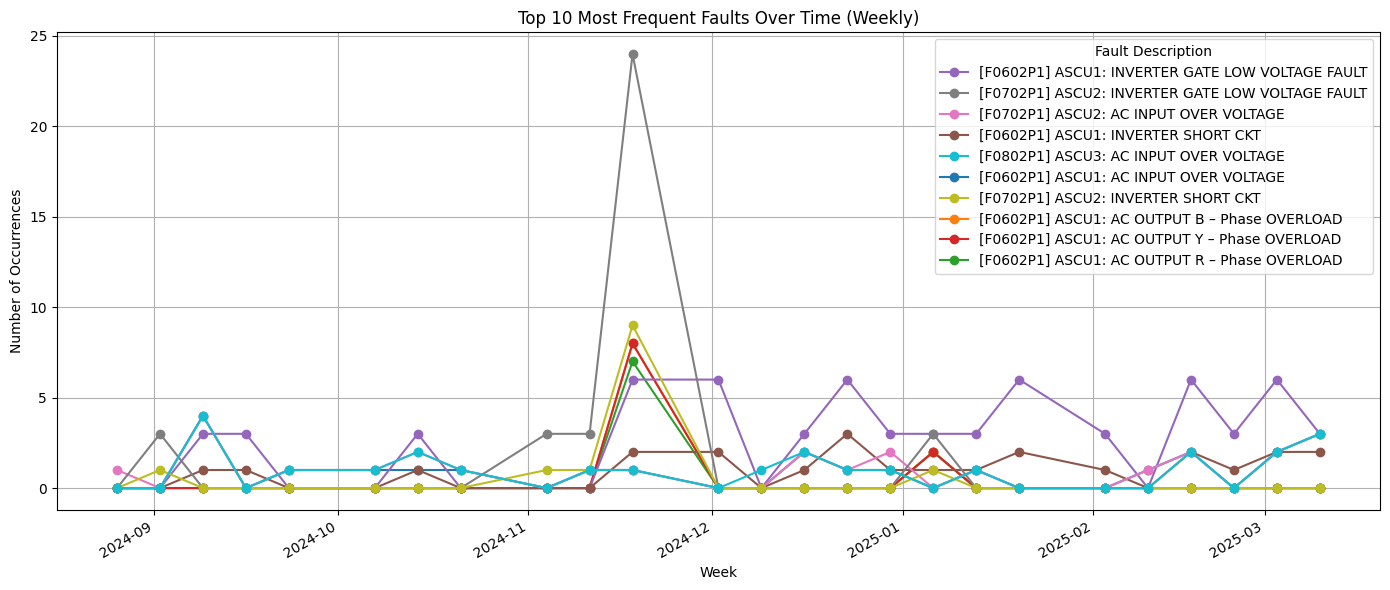

In [112]:
import matplotlib.pyplot as plt

totals = top10.sum().sort_values(ascending=False)
ax = top10.plot(marker="o", figsize=(14, 6))
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    [dict(zip(labels, handles))[l] for l in totals.index],
    totals.index,
    title="Fault Description",
    loc="upper right",
)

plt.title("Top 10 Most Frequent Faults Over Time (Weekly)")
plt.xlabel("Week")
plt.ylabel("Number of Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()

## Interactive Plot

In [113]:
import plotly.express as px

sorted_columns = top10.sum().sort_values(ascending=False).index
fig = px.line(
    top10[sorted_columns],
    markers=True,
    title="Top 10 Most Frequent Faults Over Time (Weekly)",
)
fig.update_layout(xaxis_title="Week", yaxis_title="Occurrences")
fig.show()

## Step 3.1 Forecasting for each fault from top 10 (using Prophet library)

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


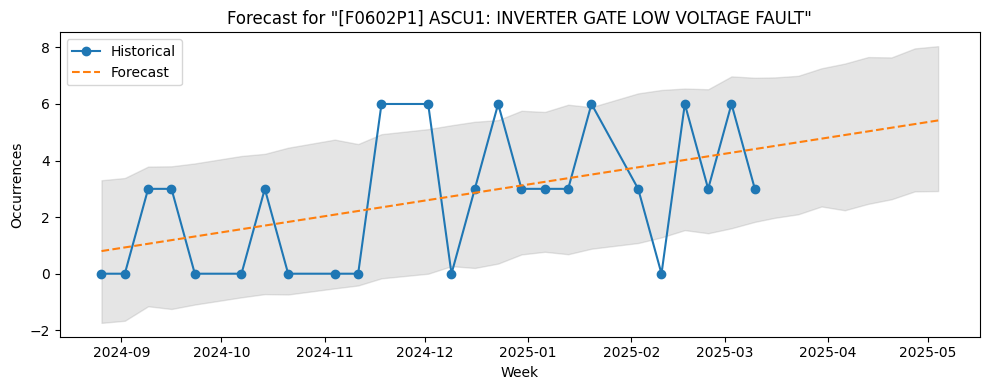

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


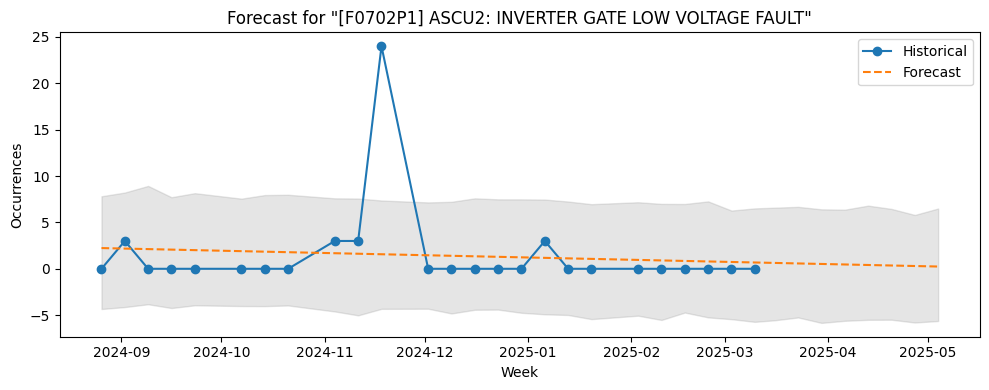

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


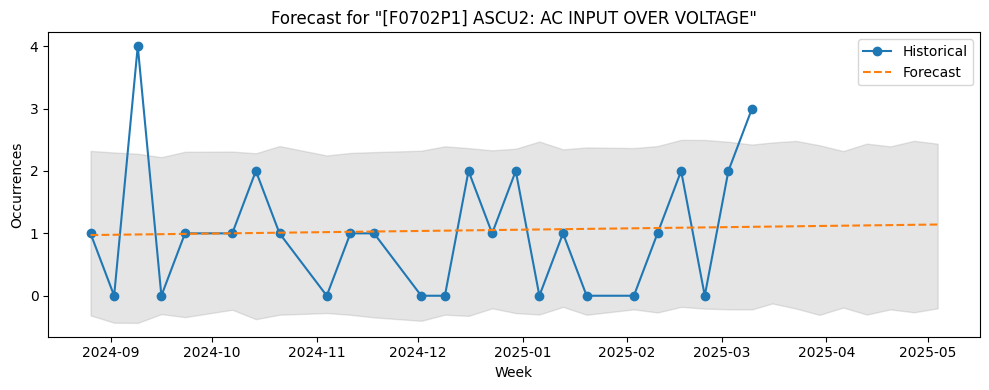

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


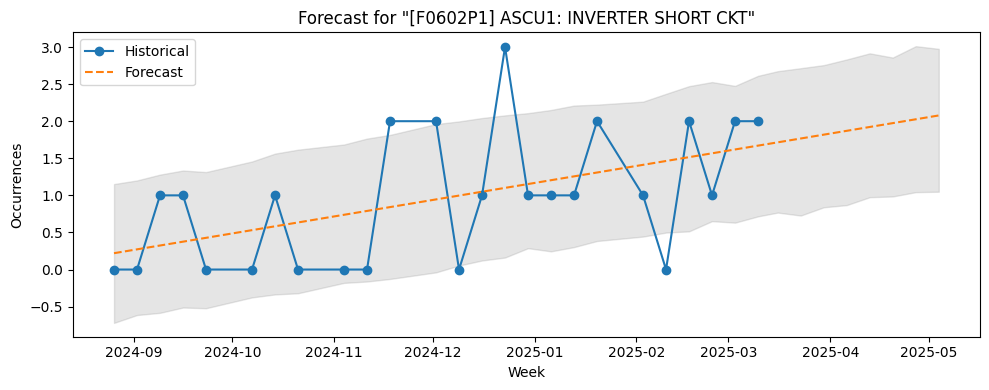

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


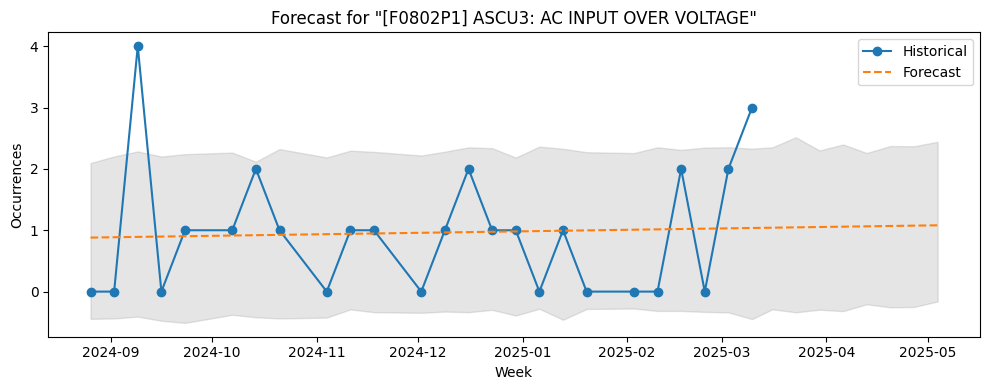

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


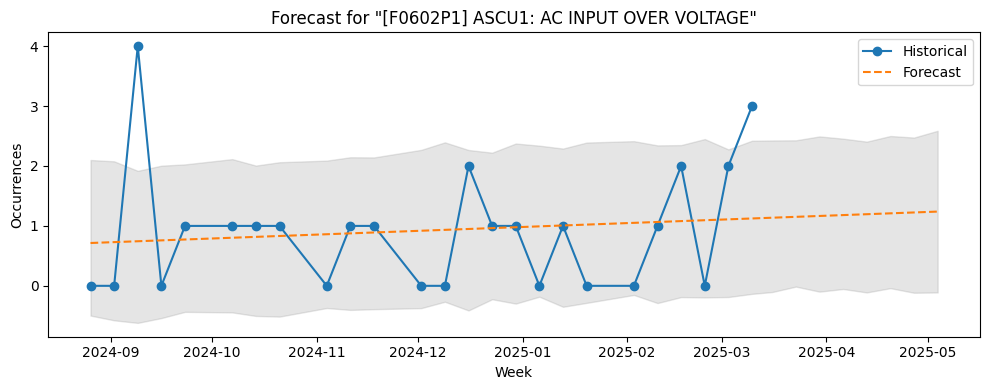

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


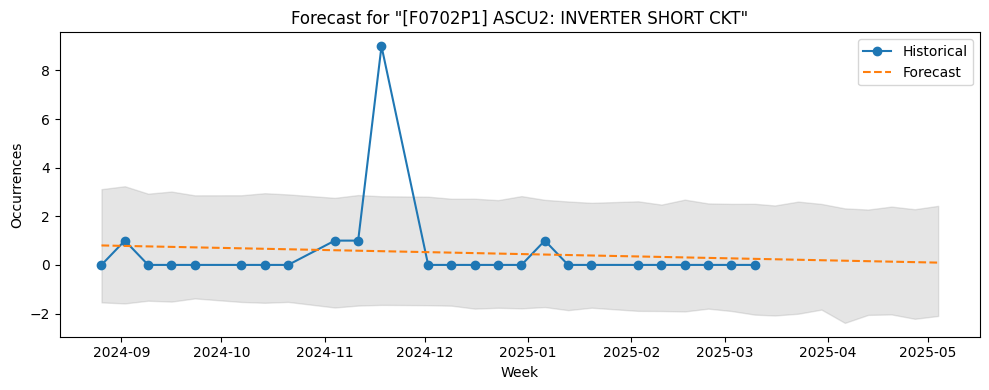

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


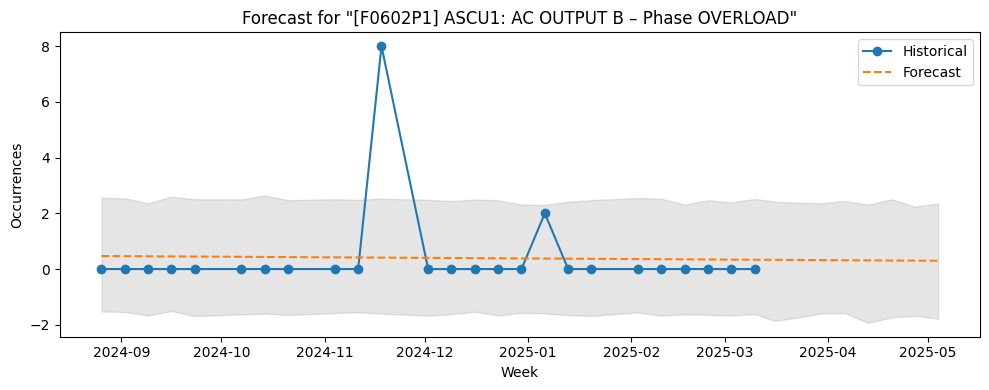

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


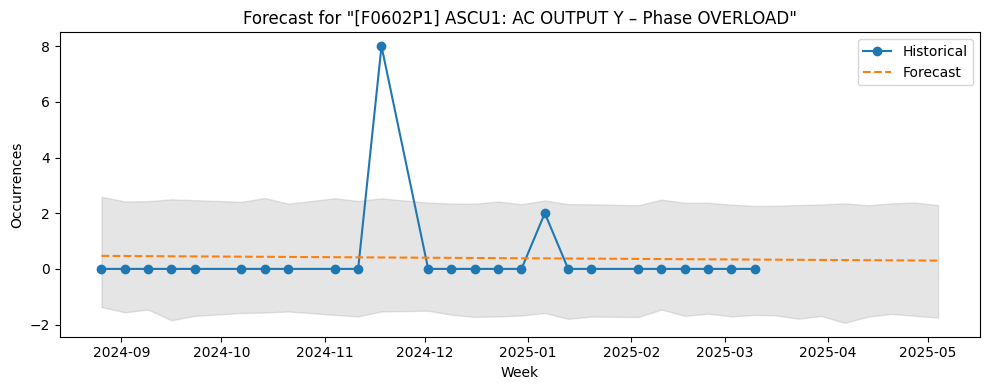

INFO	Task(Task-4) prophet:forecaster.py:set_changepoints()- n_changepoints greater than number of observations. Using 19.


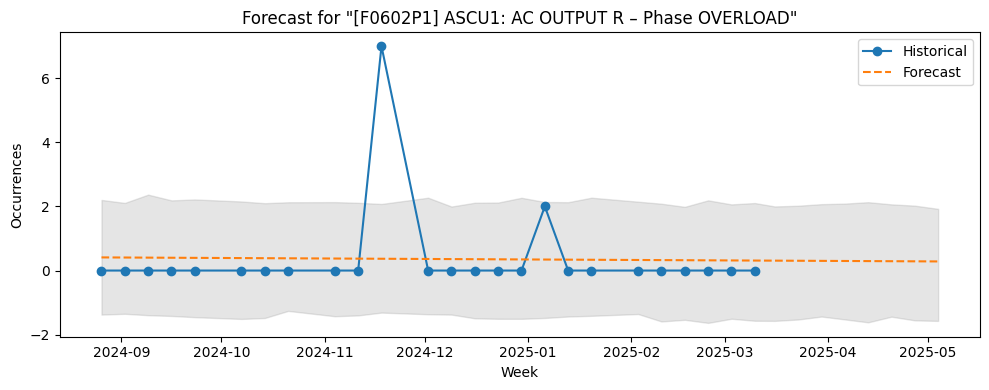

In [114]:
from prophet import Prophet
import matplotlib.pyplot as plt
# Suppress annoying cmdstanpy warnings
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

for fault in top10.sum().sort_values(ascending=False).index:
    ts = top10[fault].reset_index().rename(columns={"Week": "ds", fault: "y"})
    m = Prophet(
        weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False
    )
    m.fit(ts)
    future = m.make_future_dataframe(periods=8, freq="W")
    forecast = m.predict(future)
    plt.figure(figsize=(10, 4))
    plt.plot(ts["ds"], ts["y"], marker="o", label="Historical")
    plt.plot(forecast["ds"], forecast["yhat"], linestyle="--", label="Forecast")
    plt.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        alpha=0.2,
        color="gray",
    )
    plt.title(f'Forecast for "{fault}"')
    plt.xlabel("Week")
    plt.ylabel("Occurrences")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3.2 Forecasting using Statsmodels

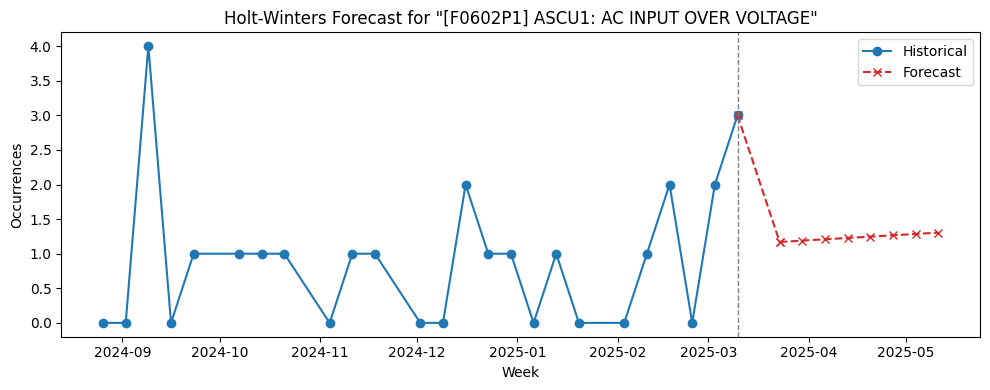

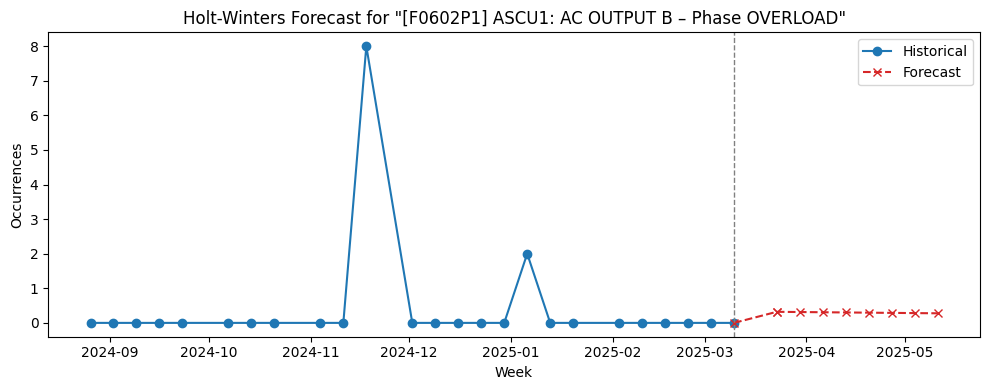

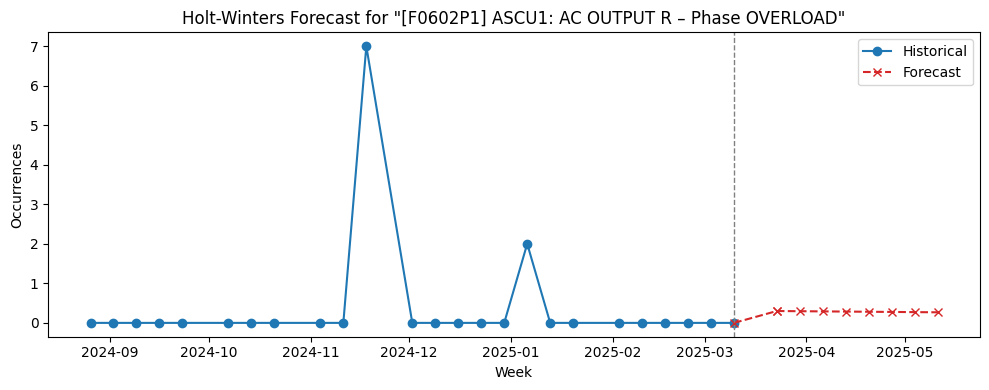

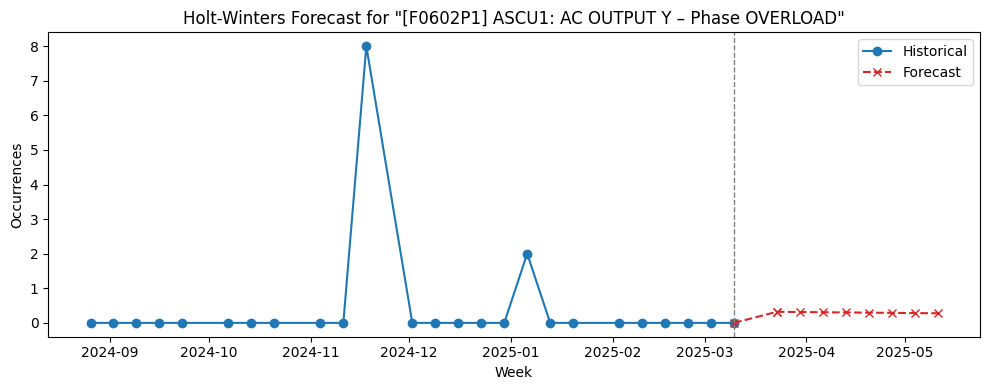

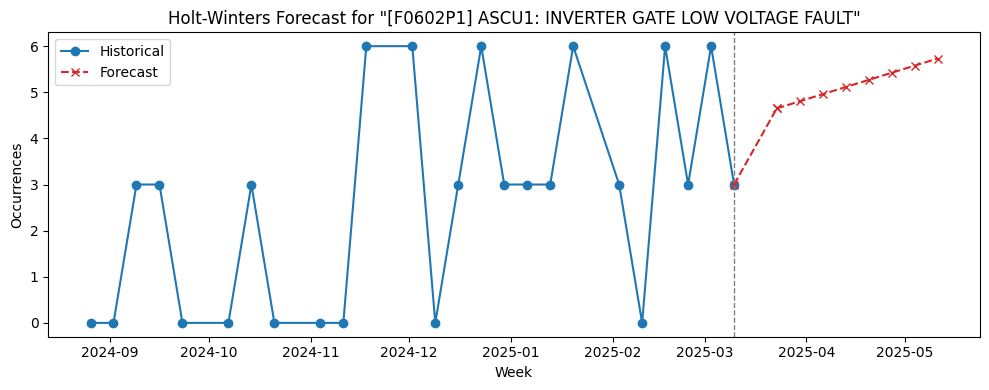

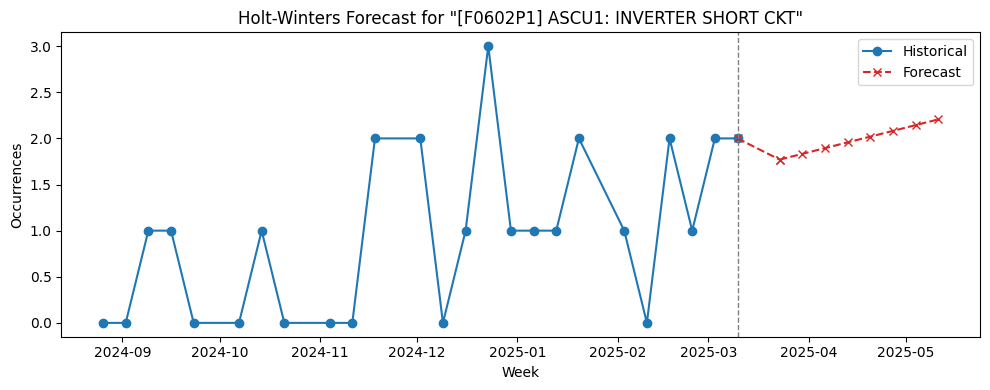

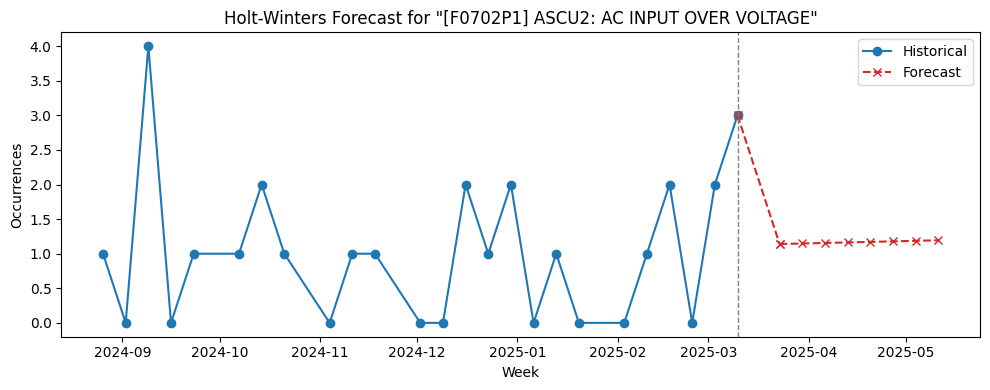

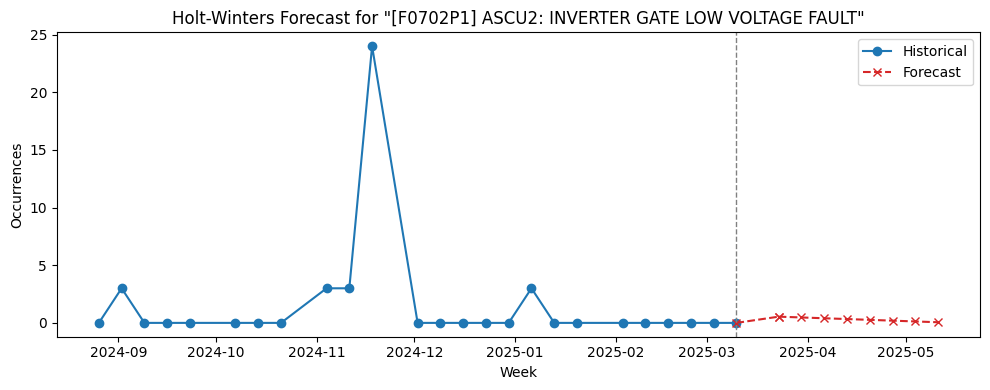

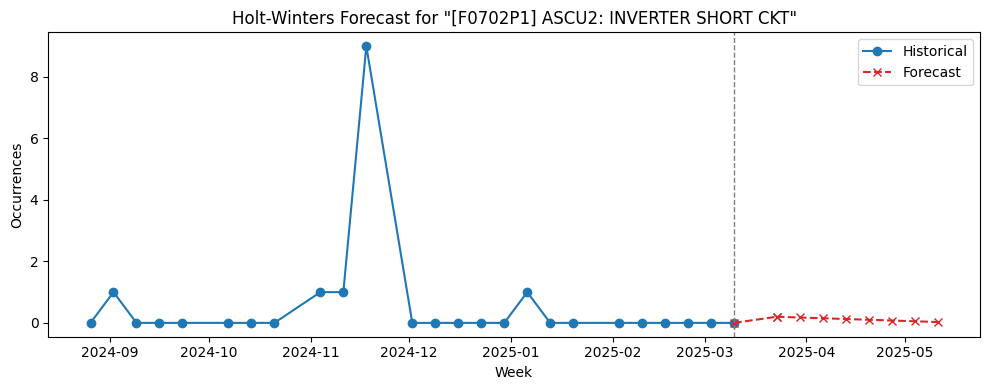

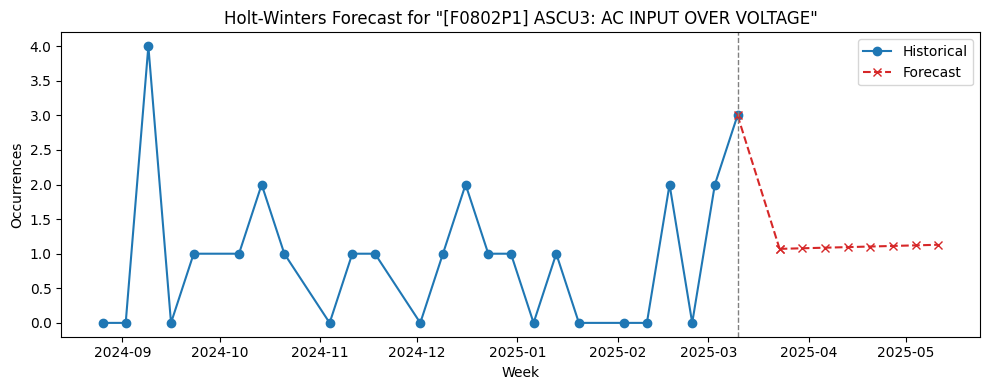

In [115]:
# Forecasting using Exponential Smoothing (Holt-Winters) for each top 10 fault

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

forecast_horizon = 8

for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        model = ExponentialSmoothing(y, trend="add", seasonal=None, initialization_method="estimated")
        fit = model.fit()
        pred_mean = fit.forecast(forecast_horizon)

        forecast_index = pd.date_range(index[-1], periods=forecast_horizon+1, freq="W")[1:]

        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        # Connect last historical point to first forecast point
        plt.plot([index[-1], forecast_index[0]], [y[-1], pred_mean[0]], color="tab:red", linestyle="--", marker="x")
        plt.plot(forecast_index, pred_mean, marker="x", linestyle="--", color="tab:red", label="Forecast")
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'Holt-Winters Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not fit Holt-Winters for '{fault}': {e}")

# 3.3 Forecasting using ARIMA

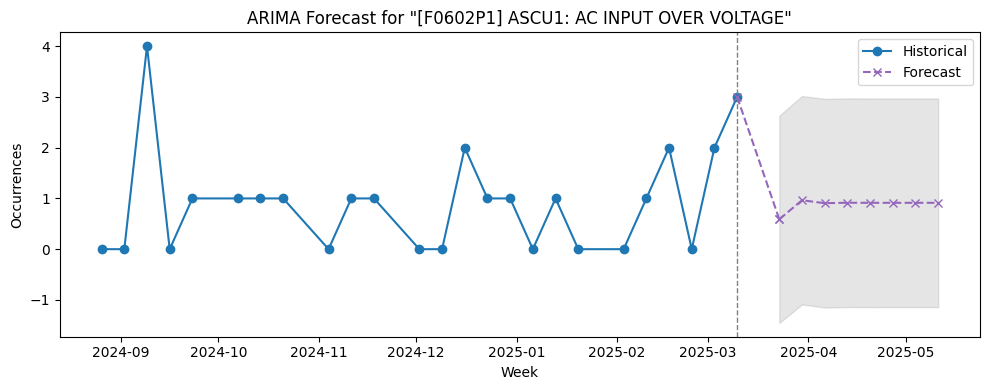

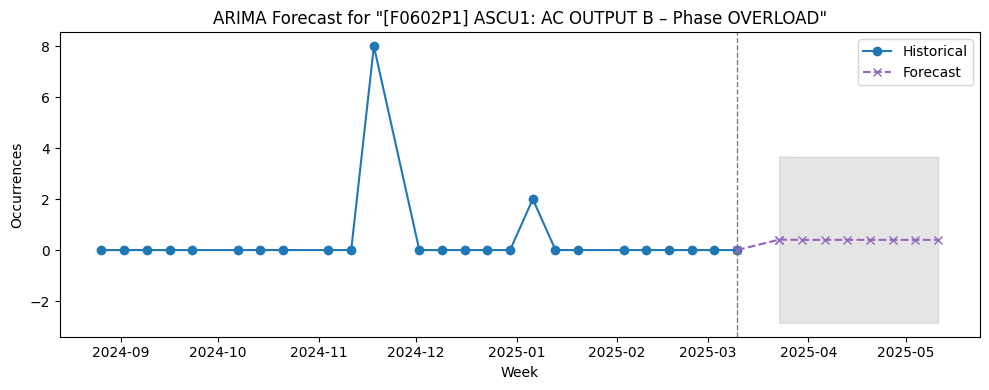

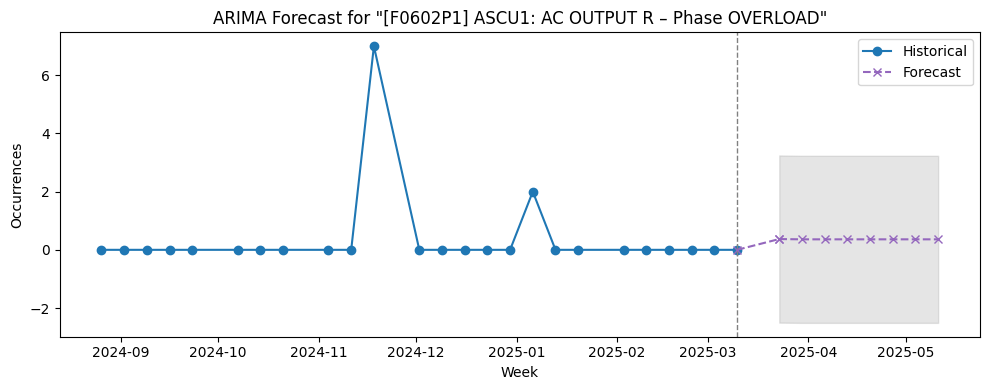

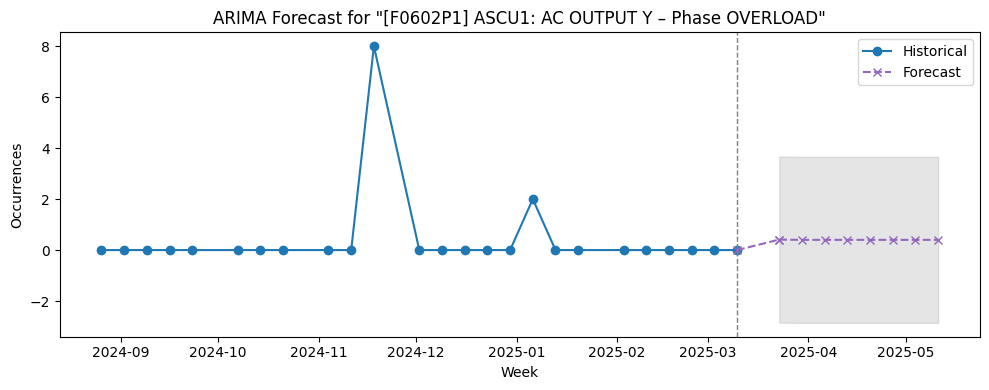

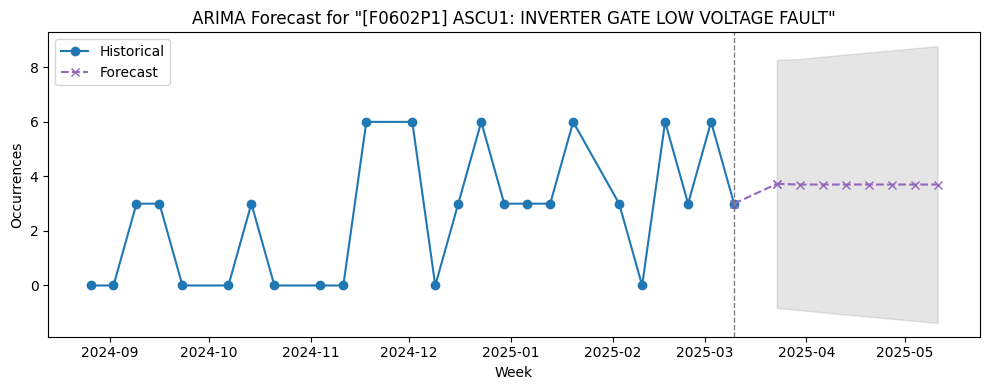

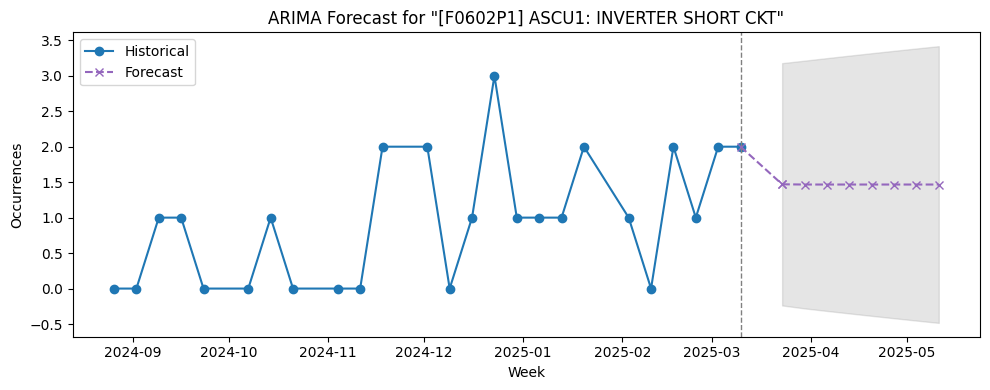

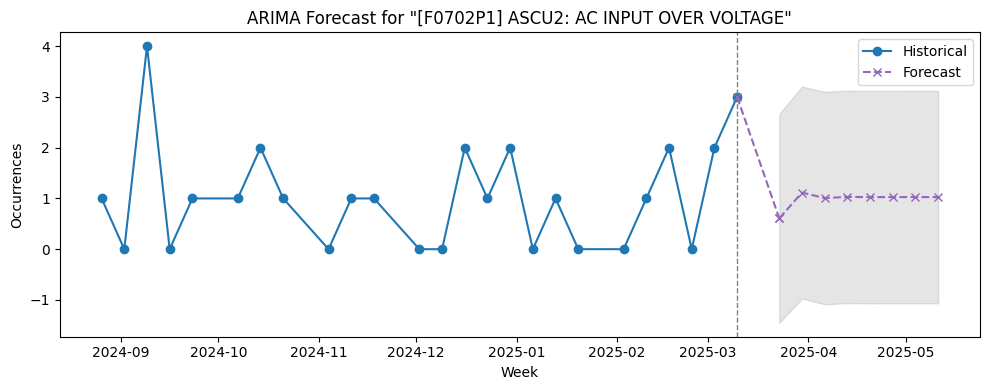

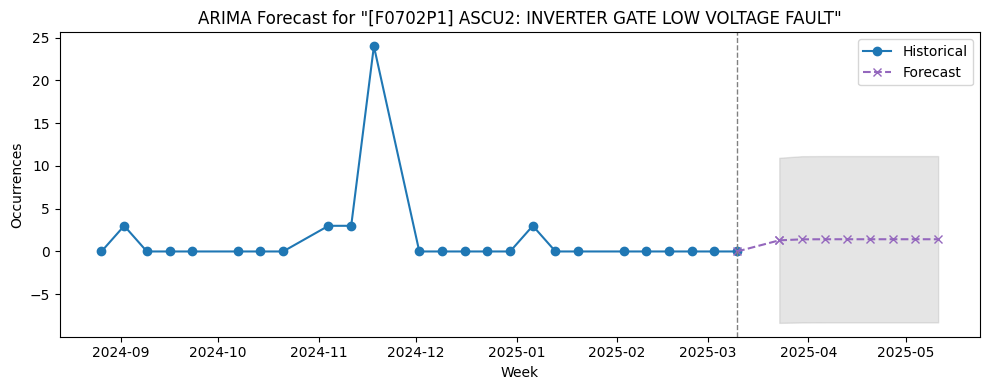

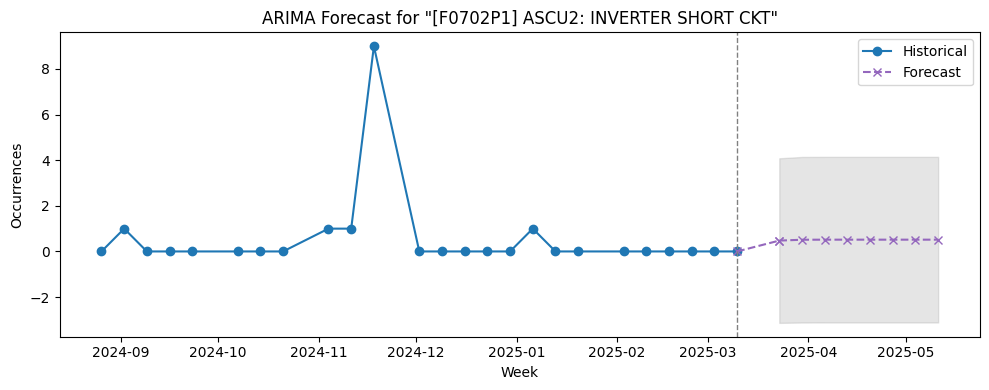

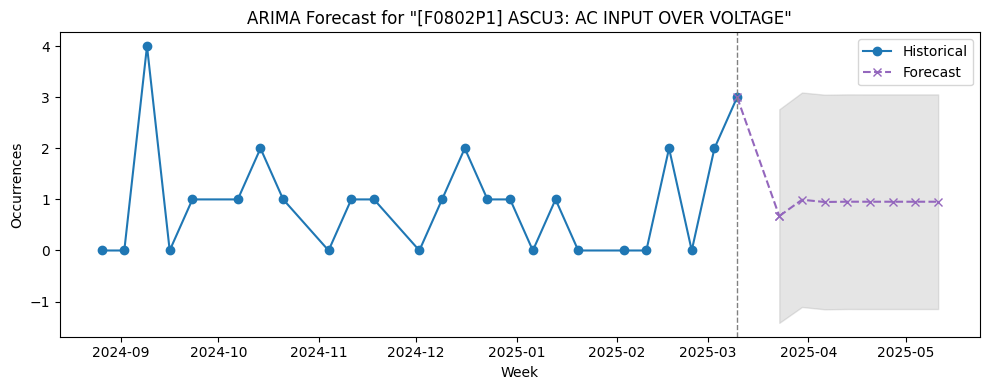

In [116]:
# Forecasting using ARIMA for each top 10 fault (annoying warnings suppressed)

import warnings
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

forecast_horizon = 8

for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        model = ARIMA(y, order=(1,1,1))
        results = model.fit()
        forecast = results.get_forecast(steps=forecast_horizon)
        pred_mean = forecast.predicted_mean
        pred_ci = forecast.conf_int()

        forecast_index = pd.date_range(index[-1], periods=forecast_horizon+1, freq="W")[1:]

        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        # Connect last historical point to first forecast point
        plt.plot([index[-1], forecast_index[0]], [y[-1], pred_mean[0]], color="tab:purple", linestyle="--", marker="x")
        plt.plot(forecast_index, pred_mean, marker="x", linestyle="--", color="tab:purple", label="Forecast")
        plt.fill_between(forecast_index, pred_ci[:, 0], pred_ci[:, 1], color="gray", alpha=0.2)
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'ARIMA Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not fit ARIMA for '{fault}': {e}")
        

# 4.1 Forecasting using scikit-learn (Machine Learning)

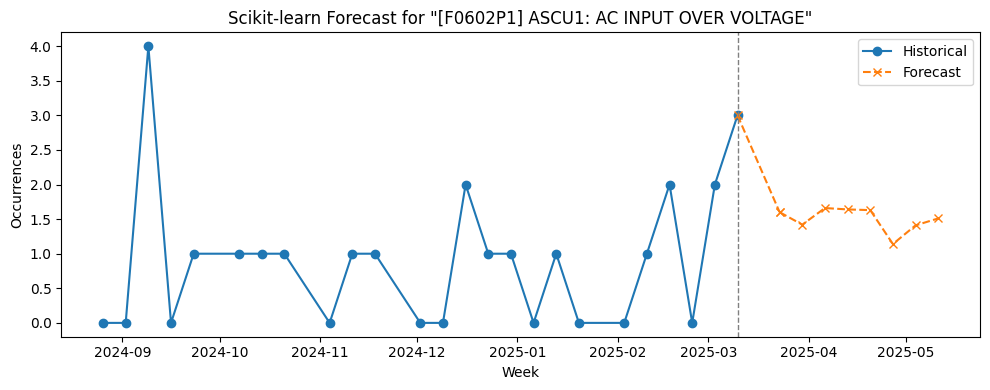

MAE (last 4 weeks) for "[F0602P1] ASCU1: AC INPUT OVER VOLTAGE": 0.38250000000000006


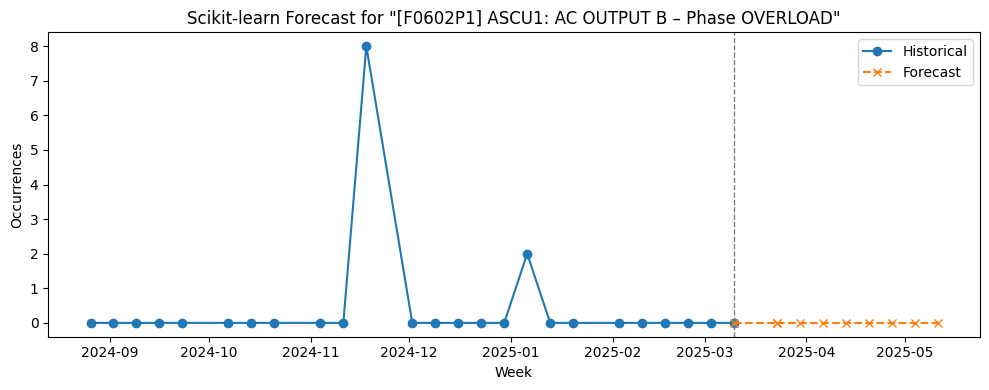

MAE (last 4 weeks) for "[F0602P1] ASCU1: AC OUTPUT B – Phase OVERLOAD": 0.0


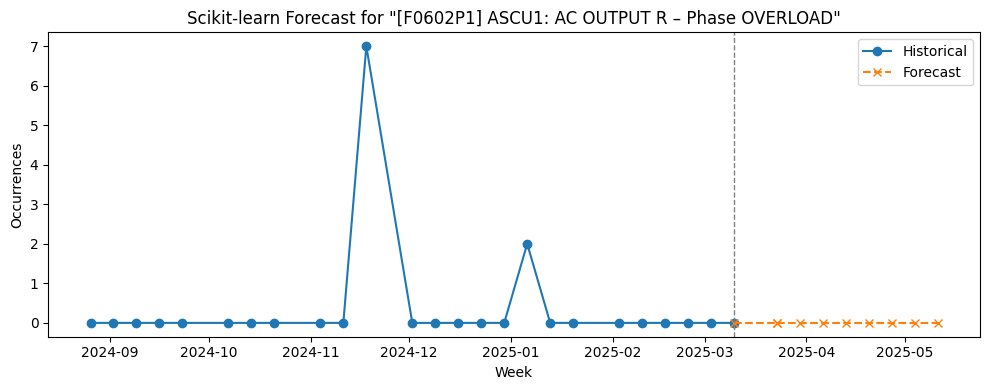

MAE (last 4 weeks) for "[F0602P1] ASCU1: AC OUTPUT R – Phase OVERLOAD": 0.0


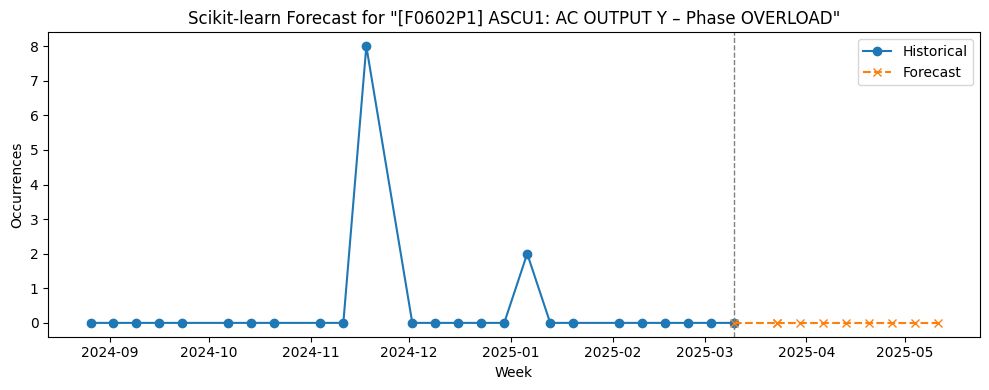

MAE (last 4 weeks) for "[F0602P1] ASCU1: AC OUTPUT Y – Phase OVERLOAD": 0.0


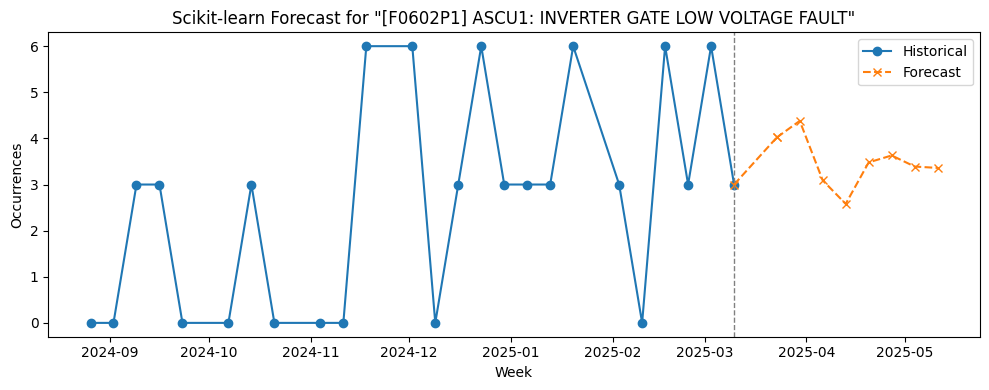

MAE (last 4 weeks) for "[F0602P1] ASCU1: INVERTER GATE LOW VOLTAGE FAULT": 0.84


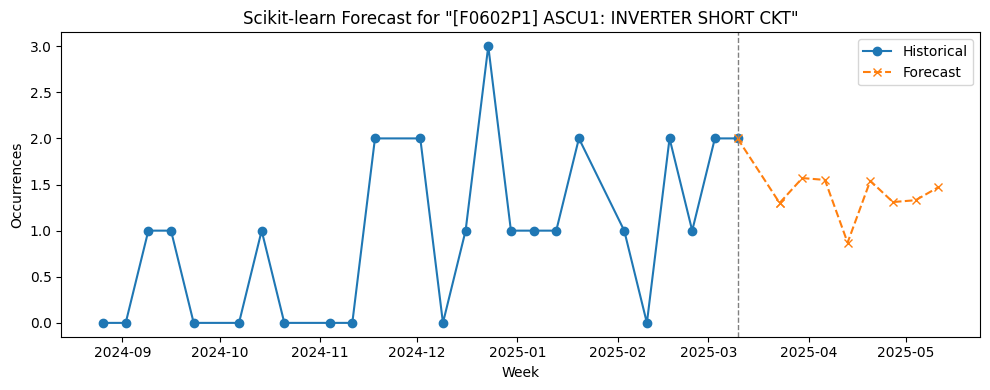

MAE (last 4 weeks) for "[F0602P1] ASCU1: INVERTER SHORT CKT": 0.3275


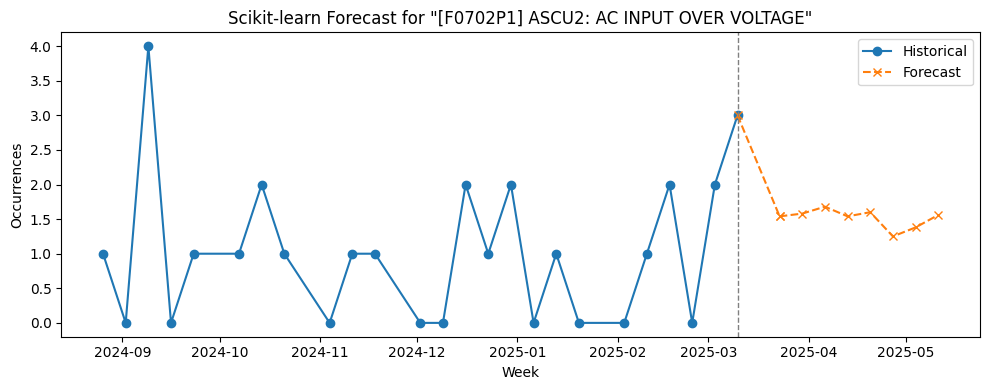

MAE (last 4 weeks) for "[F0702P1] ASCU2: AC INPUT OVER VOLTAGE": 0.395


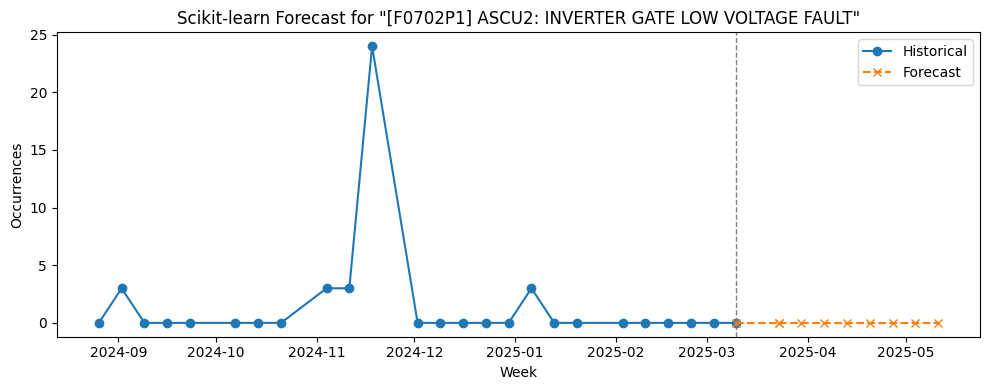

MAE (last 4 weeks) for "[F0702P1] ASCU2: INVERTER GATE LOW VOLTAGE FAULT": 0.0


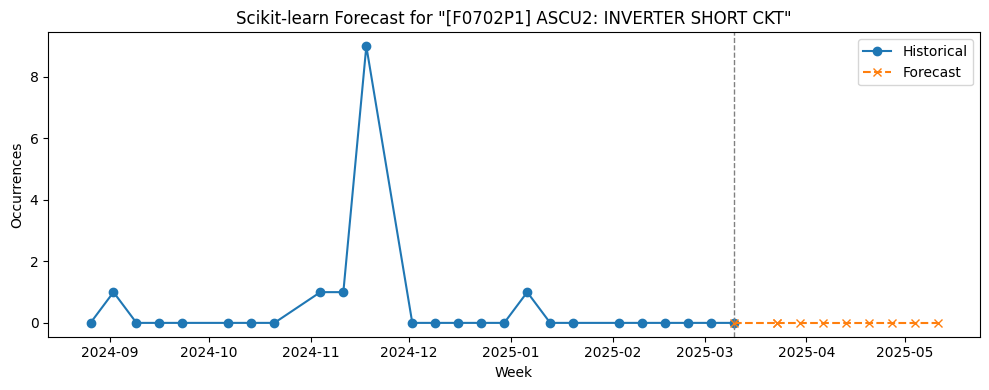

MAE (last 4 weeks) for "[F0702P1] ASCU2: INVERTER SHORT CKT": 0.0


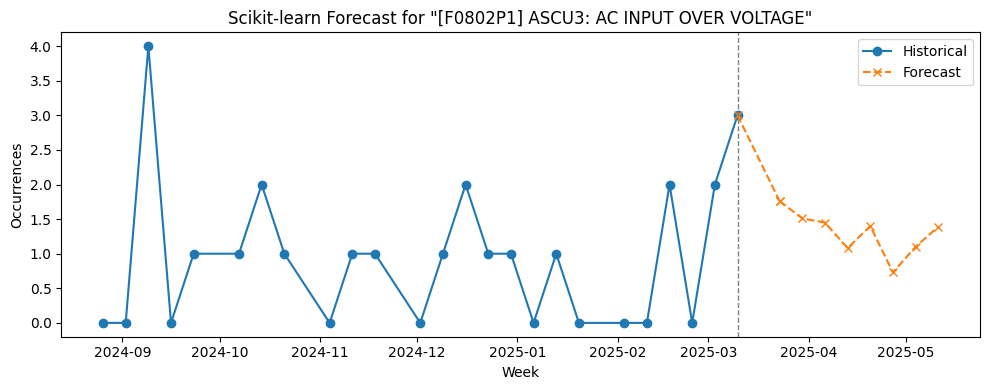

MAE (last 4 weeks) for "[F0802P1] ASCU3: AC INPUT OVER VOLTAGE": 0.385


In [123]:
# Forecasting using scikit-learn's RandomForestRegressor for each top 10 fault

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

window = 20 # Number of weeks to use for prediction
forecast_horizon = 8  # Number of weeks to forecast

for fault in top10.columns:
    y = top10[fault].values
    X, y_target = [], []
    for i in range(len(y) - window):
        X.append(y[i : i + window])
        y_target.append(y[i + window])
    X, y_target = np.array(X), np.array(y_target)
    if len(X) == 0:
        continue  # Not enough data

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y_target)

    # Forecast future
    last_window = y[-window:]
    preds = []
    window_vals = last_window.copy()
    for _ in range(forecast_horizon):
        pred = model.predict(window_vals.reshape(1, -1))[0]
        preds.append(pred)
        window_vals = np.roll(window_vals, -1)
        window_vals[-1] = pred

    # Prepare plot
    plt.figure(figsize=(10, 4))
    # Plot historical data
    plt.plot(top10.index, y, marker="o", label="Historical", color="tab:blue")
    # Prepare forecast index
    forecast_index = pd.date_range(top10.index[-1], periods=forecast_horizon+1, freq="W")[1:]
    # Connecting two lines
    plt.plot(
        [top10.index[-1], forecast_index[0]],
        [y[-1], preds[0]],
        color="tab:orange",
        linestyle="--",
        marker="x"
    )
    # Plot forecasted data
    plt.plot(forecast_index, preds, marker="x", linestyle="--", color="tab:orange", label="Forecast")
    # horizontal dashed line
    plt.axvline(x=top10.index[-1], color="gray", linestyle="dashed", linewidth=1)
    plt.title(f'Scikit-learn Forecast for "{fault}"')
    plt.xlabel("Week")
    plt.ylabel("Occurrences")
    plt.legend()
    plt.tight_layout() 
    plt.show()

    # Optional print MAE on last 4 points
    if len(y_target) > 4:
        y_pred = model.predict(X[-4:])
        print(f'MAE (last 4 weeks) for "{fault}":', mean_absolute_error(y_target[-4:], y_pred))

### ML training for XGBoost, RandomForest, and LightGBM

In [118]:
def series_to_supervised(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i - n_lags : i])
        y.append(data[i])
    return np.array(X), np.array(y)

# 4.2 Forecasting using XGBoost (Machine Learning)

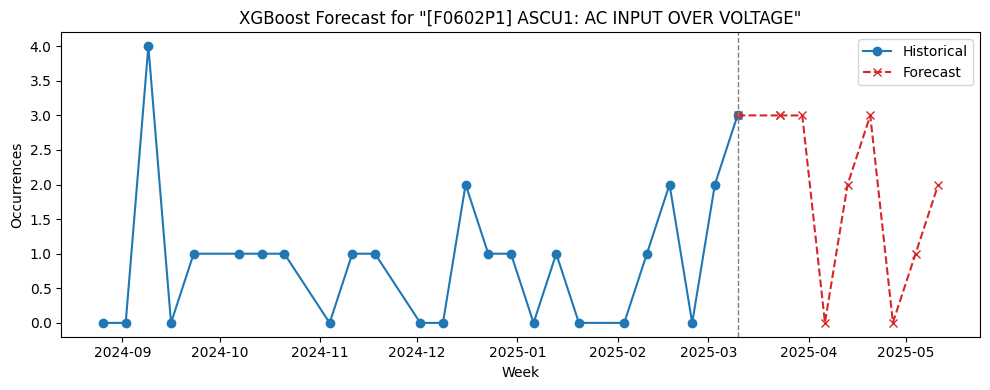

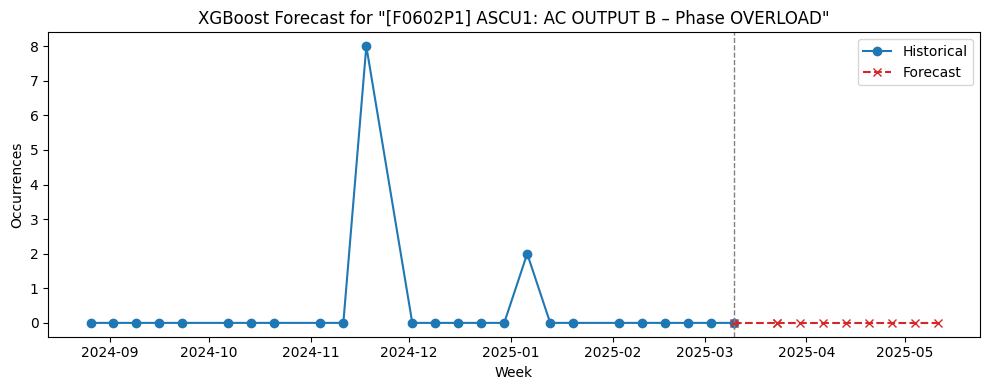

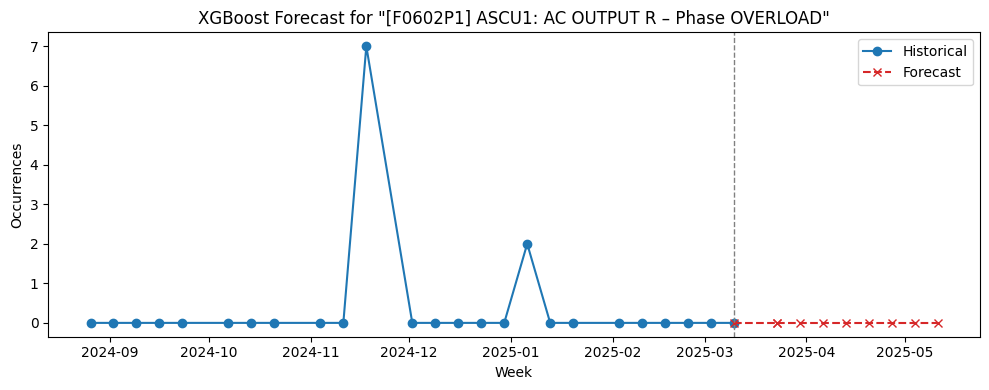

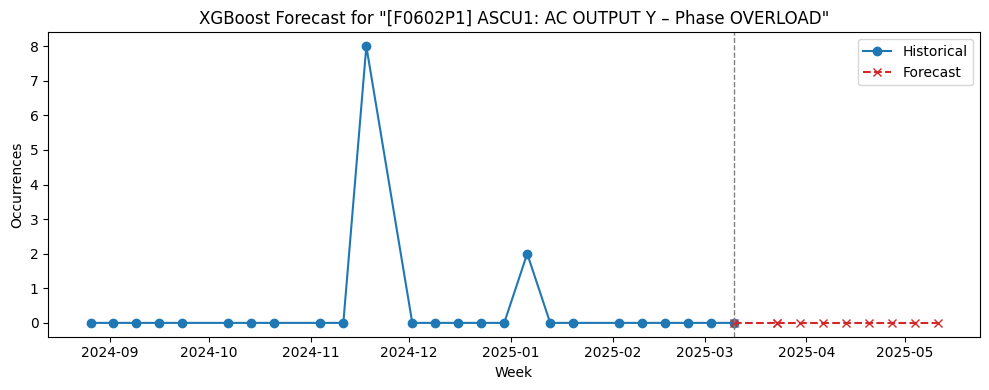

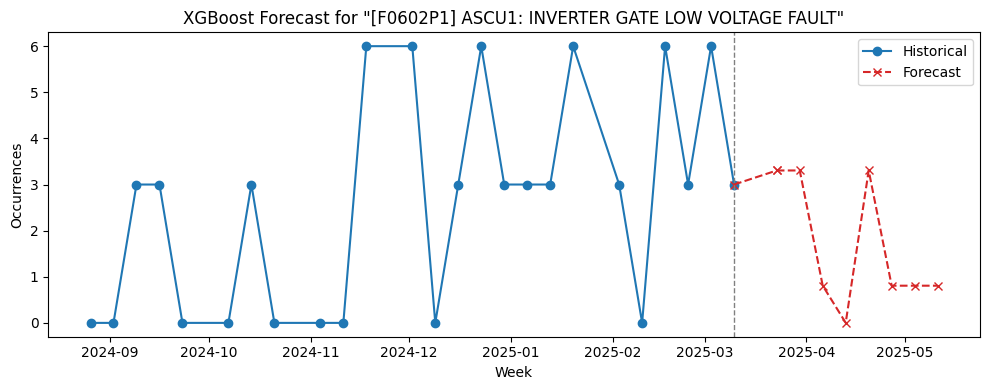

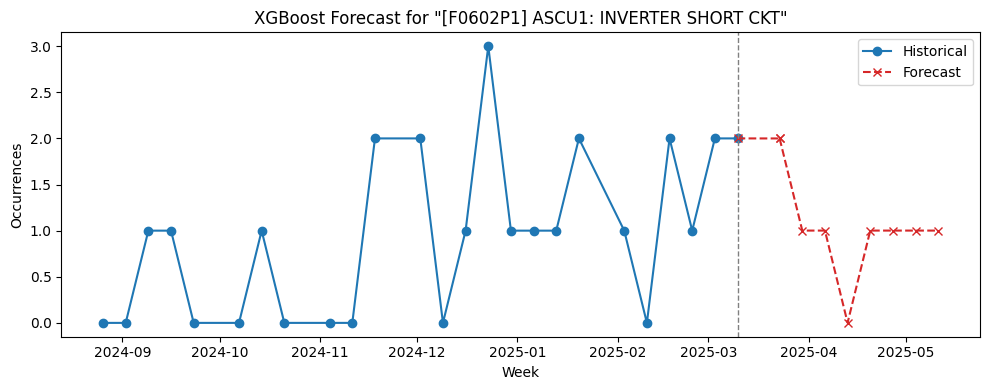

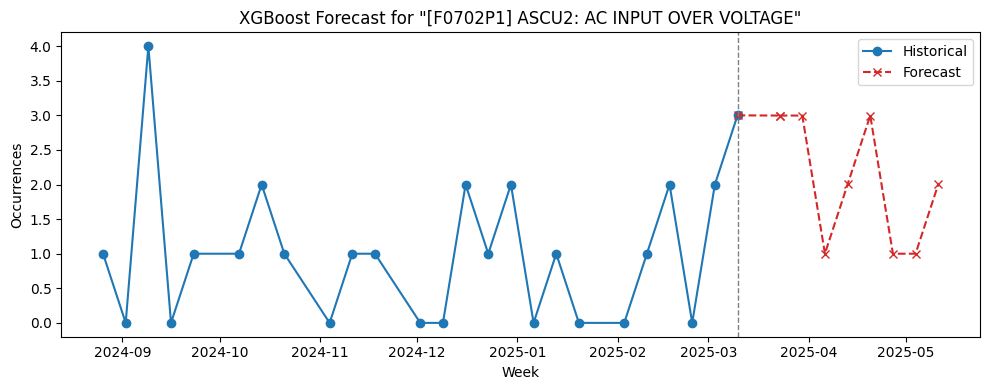

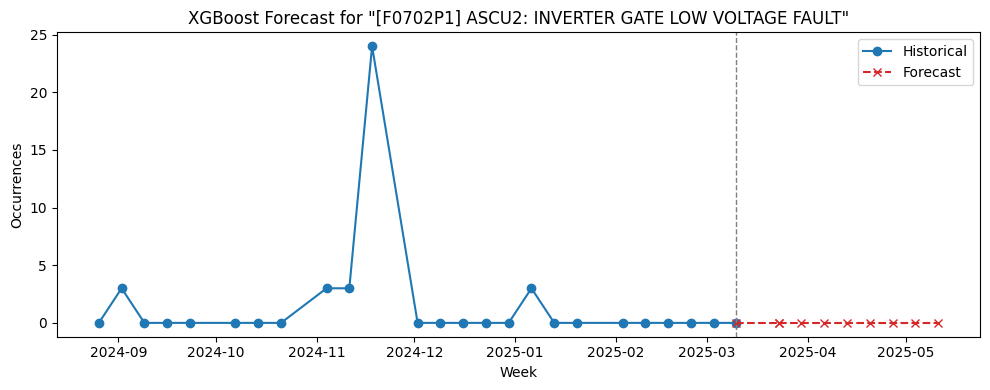

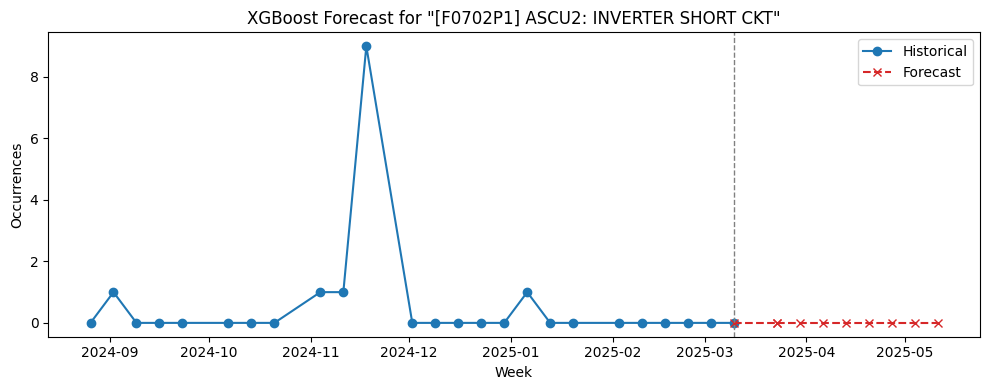

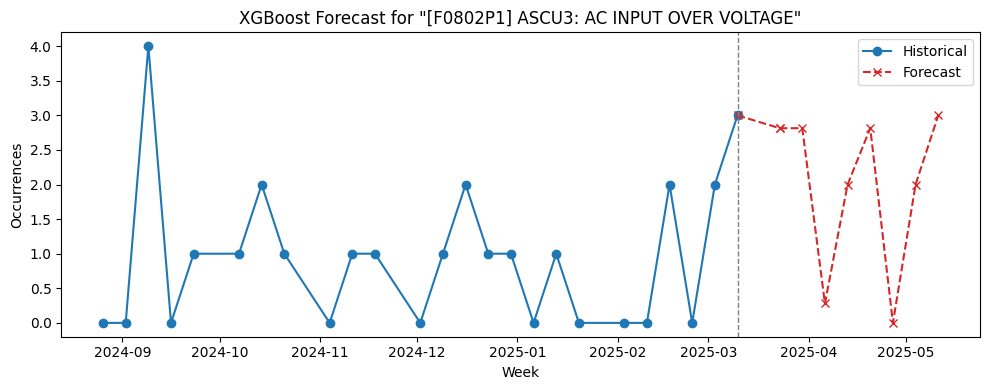

In [125]:

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

forecast_horizon = 8
n_lags = 20  # number of past weeks to use as features


for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        # Step 1: Normalize (optional)
        mean, std = y.mean(), y.std() if y.std() > 0 else 1
        y_norm = (y - mean) / std

        # Step 2: Create supervised dataset
        X, y_target = series_to_supervised(y_norm, n_lags)

        # Step 3: Train/test split
        X_train, y_train = X, y_target

        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
        model.fit(X_train, y_train)

        # Step 4: Forecast next steps iteratively
        last_seq = list(y_norm[-n_lags:])
        forecast = []

        for _ in range(forecast_horizon):
            x_input = np.array(last_seq[-n_lags:]).reshape(1, -1)
            yhat = model.predict(x_input)[0]
            forecast.append(yhat)
            last_seq.append(yhat)

        # Step 5: Inverse transform
        forecast = np.array(forecast) * std + mean
        forecast_index = pd.date_range(
            index[-1], periods=forecast_horizon + 1, freq="W"
        )[1:]

        # Step 6: Plotting
        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        plt.plot(
            [index[-1], forecast_index[0]],
            [y[-1], forecast[0]],
            color="tab:red",
            linestyle="--",
            marker="x",
        )
        plt.plot(
            forecast_index,
            forecast,
            marker="x",
            linestyle="--",
            color="tab:red",
            label="Forecast",
        )
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'XGBoost Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not forecast with XGBoost for '{fault}': {e}")


### 4.3  Random Forest Forecasting

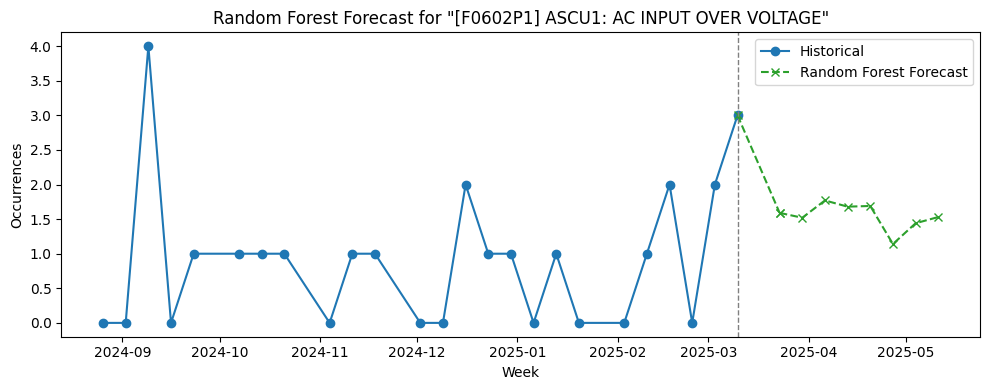

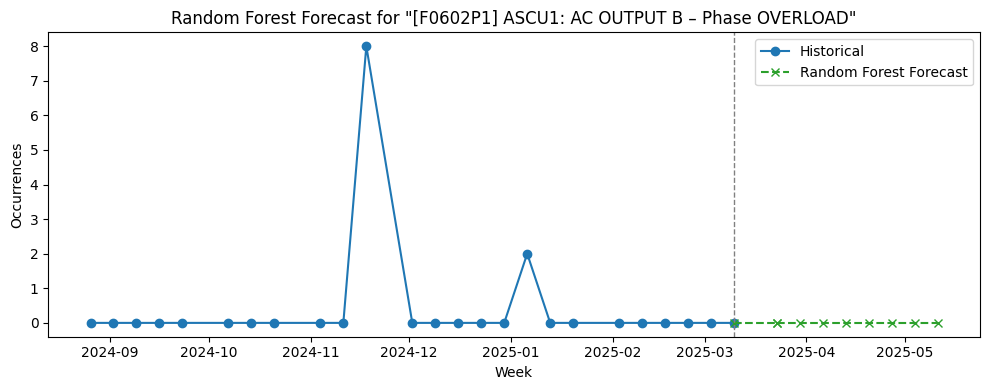

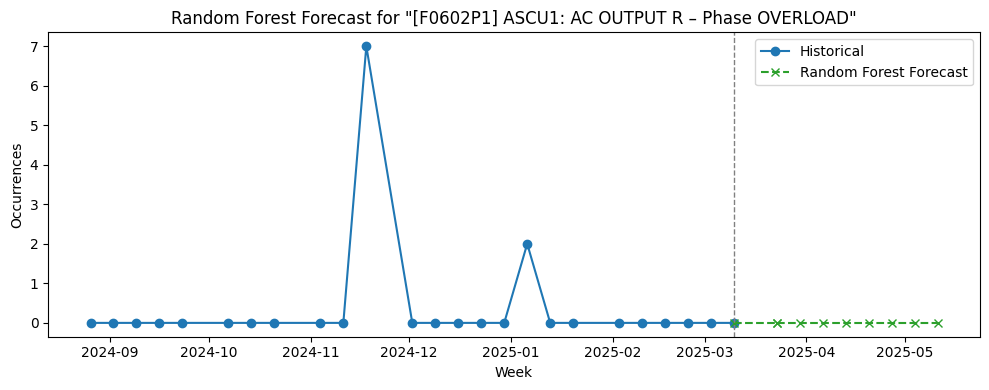

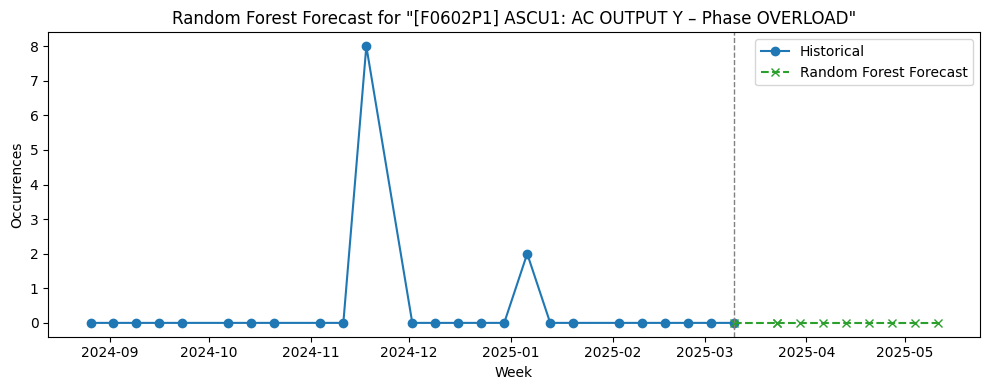

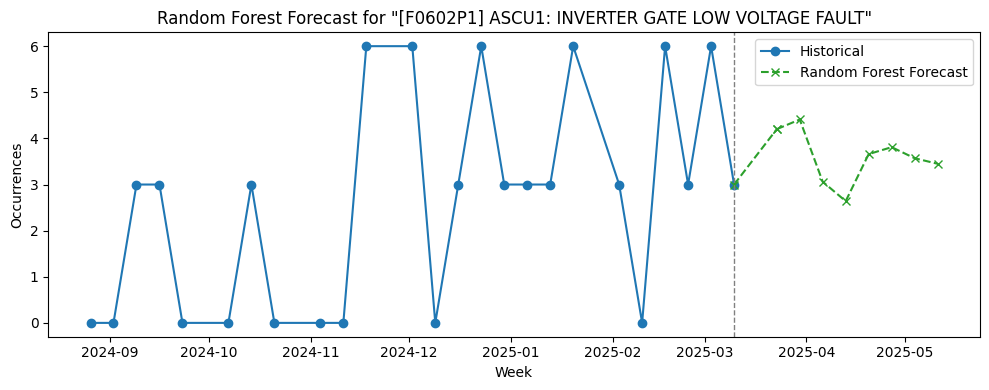

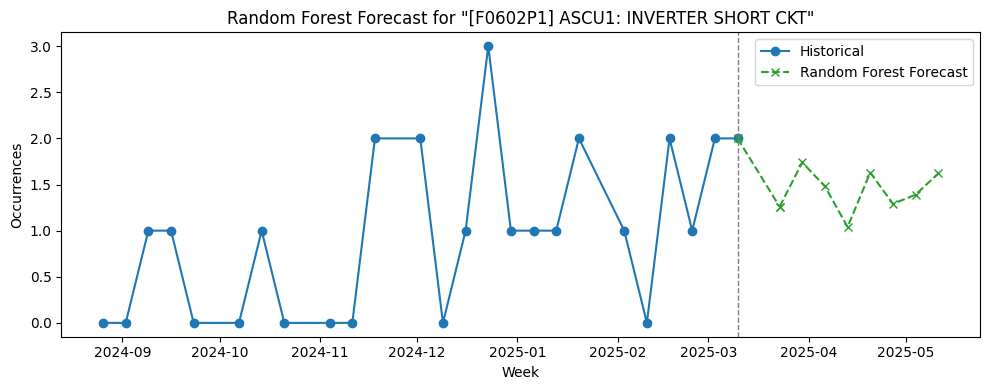

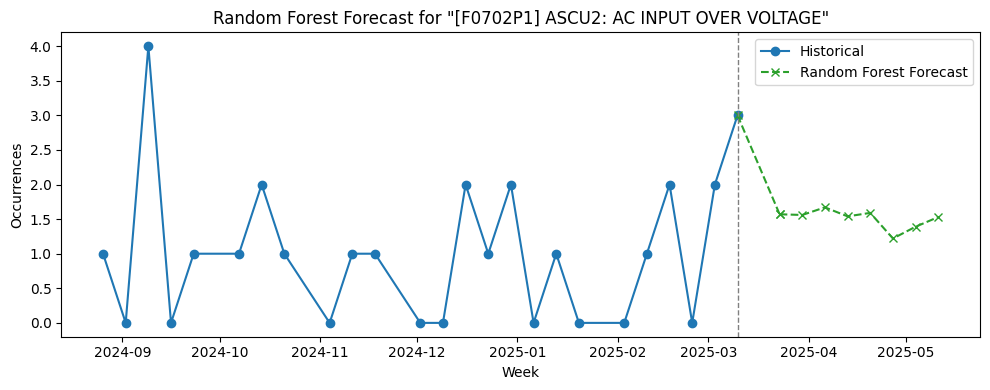

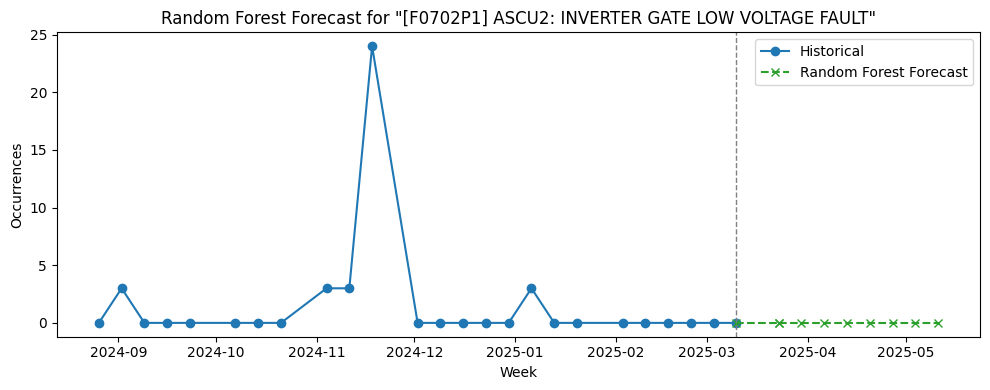

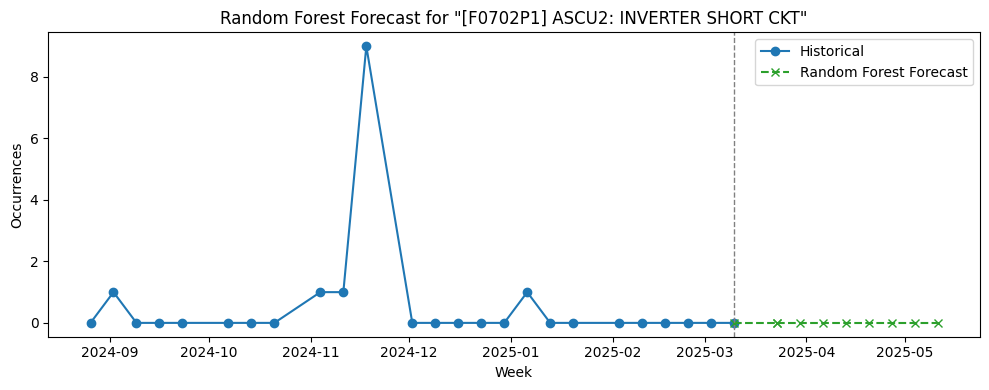

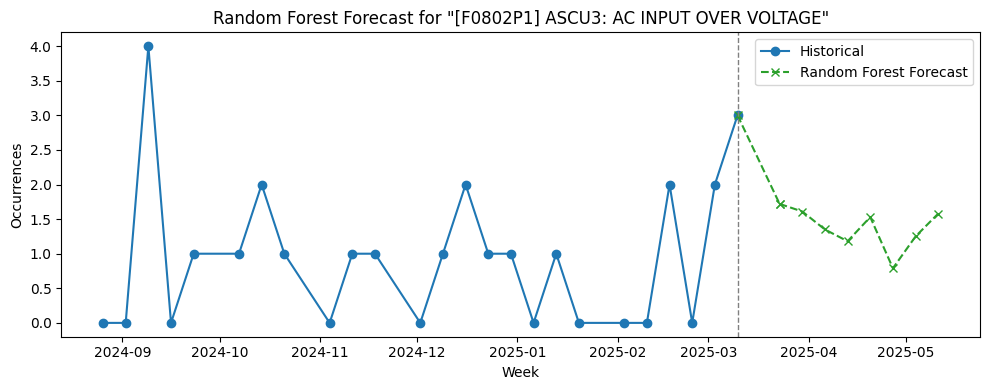

In [127]:
# --- Forecasting using Random Forest ---
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

forecast_horizon = 8
n_lags = 20

for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        mean, std = y.mean(), y.std() if y.std() > 0 else 1
        y_norm = (y - mean) / std

        X, y_target = series_to_supervised(y_norm, n_lags)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y_target)

        last_seq = list(y_norm[-n_lags:])
        forecast = []

        for _ in range(forecast_horizon):
            x_input = np.array(last_seq[-n_lags:]).reshape(1, -1)
            yhat = model.predict(x_input)[0]
            forecast.append(yhat)
            last_seq.append(yhat)

        forecast = np.array(forecast) * std + mean
        forecast_index = pd.date_range(
            index[-1], periods=forecast_horizon + 1, freq="W"
        )[1:]

        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        plt.plot(
            [index[-1], forecast_index[0]],
            [y[-1], forecast[0]],
            color="tab:green",
            linestyle="--",
            marker="x",
        )
        plt.plot(
            forecast_index,
            forecast,
            marker="x",
            linestyle="--",
            color="tab:green",
            label="Random Forest Forecast",
        )
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'Random Forest Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Random Forest failed for '{fault}': {e}")

# 4.4 LightGBM method

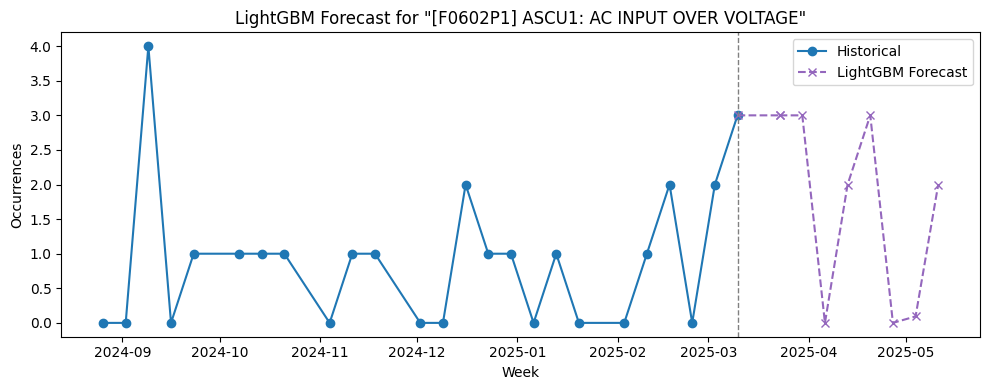

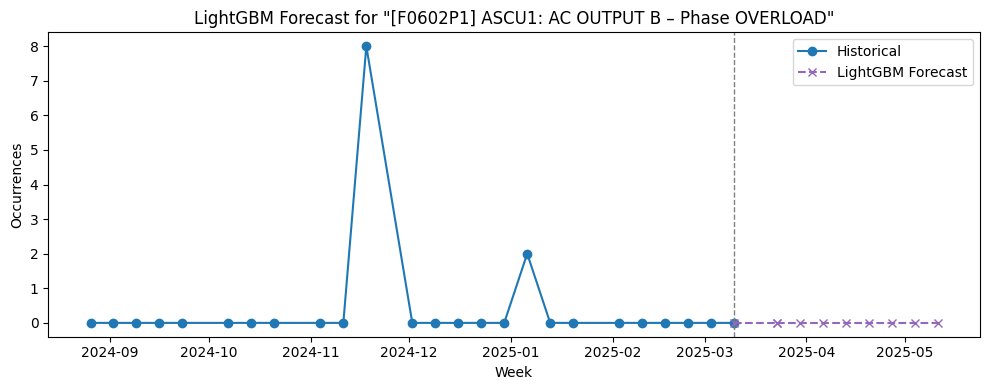

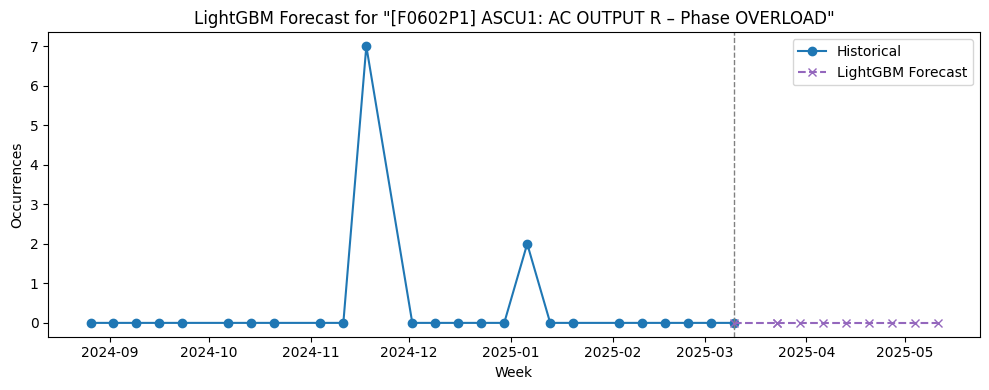

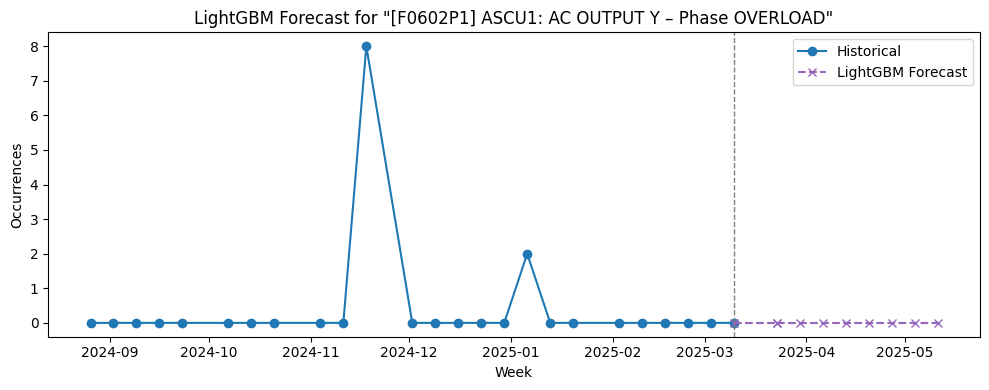

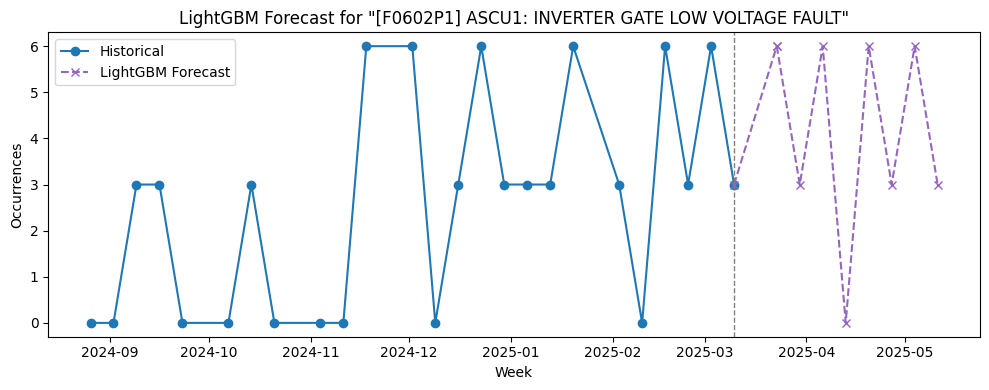

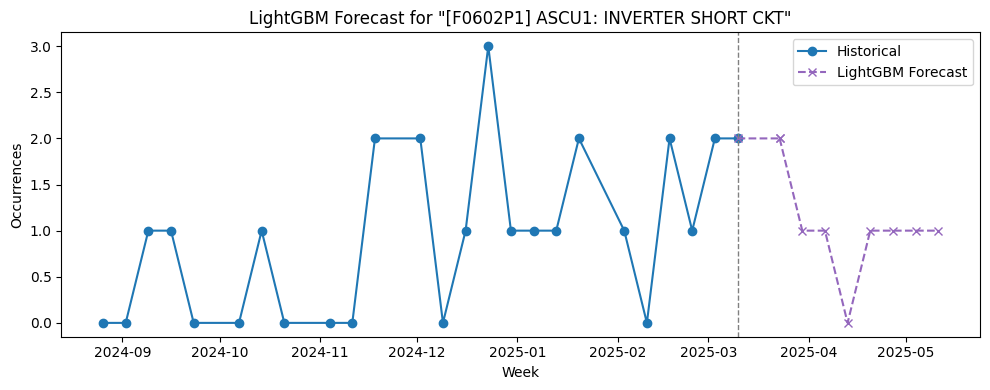

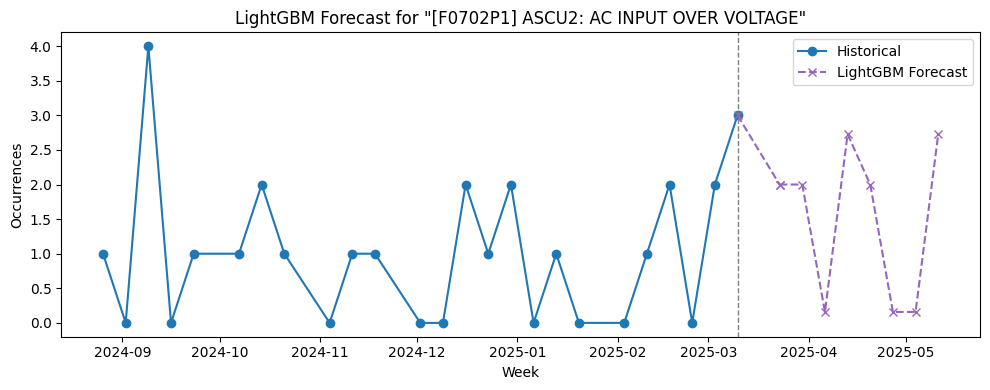

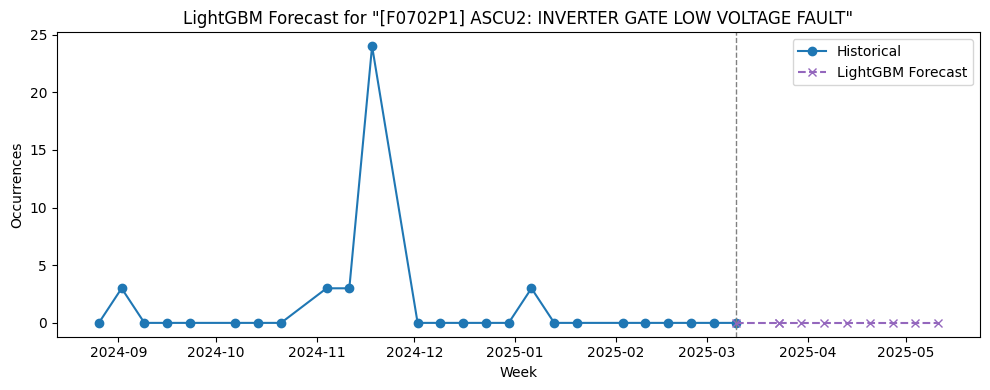

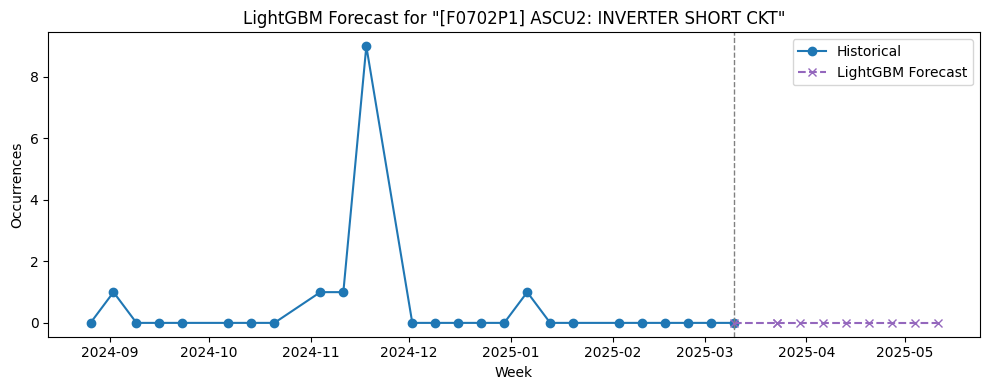

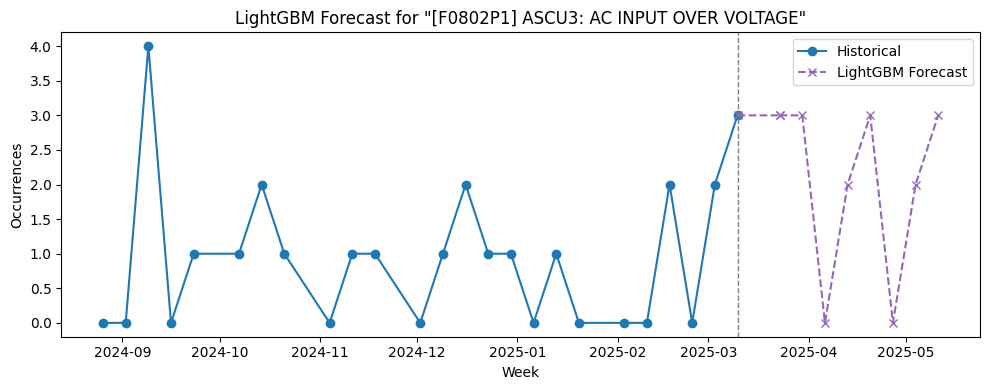

In [126]:
# --- Forecasting using LightGBM ---
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

forecast_horizon = 8
n_lags = 20

for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        mean, std = y.mean(), y.std() if y.std() > 0 else 1
        y_norm = (y - mean) / std

        X, y_target = series_to_supervised(y_norm, n_lags)
        model = lgb.LGBMRegressor(
            n_estimators=100, min_data_in_leaf=1, min_data_in_bin=1, verbosity=-1
        )
        model.fit(X, y_target)

        last_seq = list(y_norm[-n_lags:])
        forecast = []

        for _ in range(forecast_horizon):
            x_input = np.array(last_seq[-n_lags:]).reshape(1, -1)
            yhat = model.predict(x_input)[0]
            forecast.append(yhat)
            last_seq.append(yhat)

        forecast = np.array(forecast) * std + mean
        forecast_index = pd.date_range(
            index[-1], periods=forecast_horizon + 1, freq="W"
        )[1:]

        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        plt.plot(
            [index[-1], forecast_index[0]],
            [y[-1], forecast[0]],
            color="tab:purple",
            linestyle="--",
            marker="x",
        )
        plt.plot(
            forecast_index,
            forecast,
            marker="x",
            linestyle="--",
            color="tab:purple",
            label="LightGBM Forecast",
        )
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'LightGBM Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"LightGBM failed for '{fault}': {e}")